## Siamese Network for multi-view and multi-scale feature representation with Resnet as backbone for Thermogram classification
##### This notebook will demonstrate a novel multi-view and multi-scale feature representation network for classifying thermogram images

```
Author: Saqib Al Islam, University of Manitoba
```

 **Figure Representation of the network architecture**
 

---


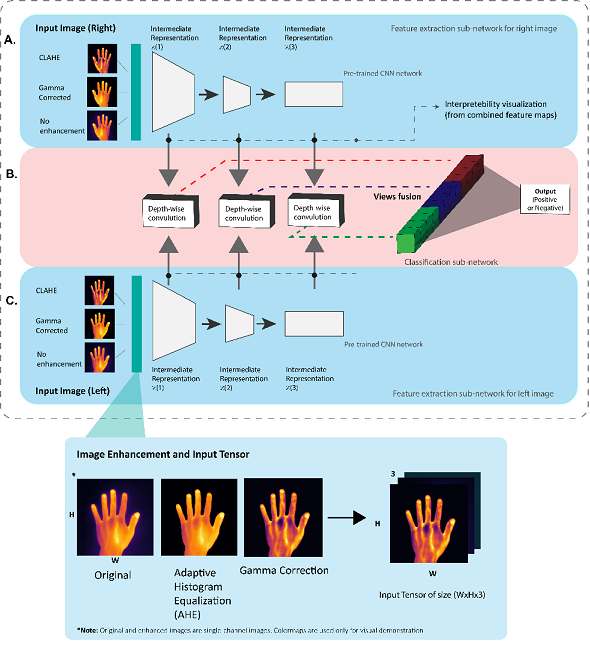

In [1]:

import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
from functools import partial

2022-06-28 13:35:59.289553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 13:35:59.289582: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# DL Imports
from numpy import concatenate
from keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D, Reshape, Dense, Flatten, Dropout, Subtract, BatchNormalization, GlobalAveragePooling2D
from keras.layers.core import Lambda
from keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import binary_crossentropy
from keras import backend as K
from keras import regularizers
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation, Add

from sklearn.metrics import log_loss
np.random.seed(1)

### Let us process the data first and prepare the **Data-Generators**

In [3]:
DATA_PATH = "/home/saqib/Plantar_Thermogram_Diabetes_Project/data/"
GENERAL_DATA_CSV = "/content/drive/MyDrive/UM_MSC/Research_Thermal_Imaging/data/ThermoDataBase/Plantar Thermogram Database.xlsx"
IMG_PATH = DATA_PATH + "CompressedData/"
TEST_PATH = DATA_PATH + "/test"
TEST_IMAGE_PATH = TEST_PATH + "/images"
ANNOT_PATH = TEST_PATH + "/annotation_results"
CSV_FILE_PATH = "/home/saqib/Plantar_Thermogram_Diabetes_Project/csvs/siamresnet/"
CHECKPOINT_FILE_PATH = DATA_PATH + "/checkpoints/"
UPDATE_FILE_PATH = DATA_PATH + "/updates/"

COMP_PATH = IMG_PATH 
ZIP_PATH = IMG_PATH + "CompressedData.zip"

In [4]:
path = Path(IMG_PATH)

In [5]:
cd $IMG_PATH

/home/saqib/Plantar_Thermogram_Diabetes_Project/data/CompressedData


## New data (Augmented)

In [54]:
def generateDataframes(Diab_R, Diab_L, Control_R, Control_L):
  Diab_R = pd.DataFrame.from_dict({"path":Diab_R, "labels":np.ones(len(Diab_R), dtype=np.int8)})
  Diab_L = pd.DataFrame.from_dict({"path":Diab_L, "labels":np.ones(len(Diab_L), dtype=np.int8)})
  Control_R = pd.DataFrame.from_dict({"path":Control_R, "labels":np.zeros(len(Control_R), dtype=np.int8)})
  Control_L = pd.DataFrame.from_dict({"path":Control_L, "labels":np.zeros(len(Control_L), dtype=np.int8)})

  Right = pd.concat([Diab_R, Control_R])
  Left = pd.concat([Diab_L, Control_L])

  PMT = np.random.permutation(len(Right))
  Right = Right.iloc[PMT]
  Left = Left.iloc[PMT]
  return (Right, Left)


AugmentedPath = ["","/Augmented1","/Augmented2","Augmented3"]
augidx = 3

DataPath = IMG_PATH + "Train" + AugmentedPath[augidx]
TrainDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
TrainDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
TrainCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
TrainCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]

DataPath = IMG_PATH + "Validation" + AugmentedPath[augidx]
ValDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
ValDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
ValCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
ValCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]

DataPath = IMG_PATH + "Test" + "/Corrected"
TestDM_L = [DataPath + "/DM_L/" + s for s in sorted(os.listdir(DataPath + "/DM_L/"))]
TestDM_R = [DataPath + "/DM_R/" + s for s in sorted(os.listdir(DataPath + "/DM_R/"))]
TestCG_L = [DataPath  + "/CG_L/" + s for s in sorted(os.listdir(DataPath  + "/CG_L/"))]
TestCG_R = [DataPath  + "/CG_R/" + s for s in sorted(os.listdir(DataPath  + "/CG_R/" ))]



TrainRight, TrainLeft = generateDataframes(TrainDM_R, TrainDM_L, TrainCG_R, TrainCG_L)
ValRight, ValLeft = generateDataframes(ValDM_R, ValDM_L, ValCG_R, ValCG_L)
TestRight, TestLeft = generateDataframes(TestDM_R, TestDM_L, TestCG_R, TestCG_L)

FileNotFoundError: [Errno 2] No such file or directory: '/home/saqib/Plantar_Thermogram_Diabetes_Project/data/CompressedData/TrainAugmented3/DM_L/'

In [ ]:
print(f"Train : DM {len(TrainDM_R)} CG {len(TrainCG_R)} Total {len(TrainDM_R) + len(TrainCG_R)} ")
print(f"Validation : DM {len(ValDM_R)} CG {len(ValCG_R)} Total {len(ValDM_R) + len(ValCG_R)}")
print(f"Test : DM {len(TestDM_R)} CG {len(TestCG_R)} Total {len(TestDM_R) + len(TestCG_R)}")
print(f"Total Pairs {len(TrainDM_R) + len(TrainCG_R) + len(ValDM_R) + len(ValCG_R) + len(TestDM_R) + len(TestCG_R)}")

Train : DM 1050 CG 1047 Total 2097 
Validation : DM 300 CG 300 Total 600
Test : DM 13 CG 6 Total 19
Total Pairs 2716


##### Image enhancement functions

In [55]:
import scipy as sp
import cv2 as cv
import PIL
def adjust_gamma(image, gamma=0.6):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
  # img = PIL.Image.fromarray(image).convert('RGB') 
  img = cv.cvtColor(np.float32(np.array(image)), cv.COLOR_BGR2GRAY)
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
    for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
  return cv.LUT(image, table)
 
def adjust_clahe(image):
  # img = PIL.Image.fromarray(image).convert('RGB') 
  img = cv.cvtColor(np.array(image), cv.COLOR_BGR2GRAY)
  #img[img < 90] = 0
  # create a CLAHE object (Arguments are optional).
  clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  im = clahe.apply(img)
  # imC = cv.applyColorMap(im, cv.COLORMAP_INFERNO)
  return im

### Custom Data Generator for input [Right image, Left image] output: [Class]

In [56]:
ENHANCEMENT_TYPE = dict({"Clahe":"clahe", "Gamma":"gamma", "None":"none","All":"all"})

# class CustomLRDataGen(tf.keras.utils.Sequence):
    
#     def __init__(self, df0 , df1, X_col = {"path":"path"}, y_col = { "label":"labels" },
#                  batch_size = 8,
#                  input_size=(128, 128),
#                  num_classes = 2,
#                  image_enhancement=ENHANCEMENT_TYPE["None"],
#                  shuffle=True):
        
#         self.df0 = df0.copy()
#         self.df1 = df1.copy()
#         self.X_col = X_col
#         self.y_col = y_col
#         self.batch_size = batch_size
#         self.input_size = input_size
#         self.shuffle = shuffle
#         self.num_classes = num_classes
#         self.labels = df0["labels"].values
#         self.image_enhancement=image_enhancement
#         self.n = len(self.df1) # Size of data available. Since left and right images in same number we can take either

#     def __getitem__(self, index):
    
#       batches0 = self.df0[index * self.batch_size:(index + 1) * self.batch_size]
#       batches1 = self.df1[index * self.batch_size:(index + 1) * self.batch_size]
#       X, y = self.__get_data(batches0, batches1)        
#       return X, y

#     def __get_data(self, batches0, batches1):
#       # Generates data containing batch_size samples

#       input0_batch = batches0[self.X_col['path']] # Load batch of paths for right images
#       input1_batch = batches1[self.X_col['path']] # Load batch of paths for left images
#       label_batch = batches0[self.y_col['label']] # Both left and right image class will be same
      

#       X_batch0 = np.asarray([self.__get_input(x, self.input_size) for x in input0_batch])
#       X_batch1 = np.asarray([self.__get_input(x, self.input_size) for x in input1_batch])
#       y_batch = ([y for y in label_batch],[y for y in label_batch],[y for y in label_batch])


#       return tuple([X_batch0, X_batch1]), y_batch
    
#     def __get_input(self, path, target_size):
#         image0 = tf.keras.preprocessing.image.load_img(path).convert("RGB")

#         if(self.image_enhancement == ENHANCEMENT_TYPE["Clahe"]):
#           # DO CLAHE Enhancement
#           image0 = adjust_clahe(image0)
#           img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
#           img2[:,:,0] = image0 # same value in each channel
#           img2[:,:,1] = image0
#           img2[:,:,2] = image0
#           image0 = img2

#         elif(self.image_enhancement == ENHANCEMENT_TYPE["Gamma"]):
#           # DO Gamma Enhancement
#           image0 = np.array(image0).astype("uint8")
#           image0 = adjust_gamma(image0)
        

#         elif(self.image_enhancement == ENHANCEMENT_TYPE["None"]):
#           # DO Gamma Enhancement
#           image0 = image0
#         elif(self.image_enhancement == ENHANCEMENT_TYPE["All"]):
#           # DO Gamma Enhancement
#           clahe = adjust_clahe(image0)
#           gamma = np.array(image0).astype("uint8")
#           img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
#           img2[:,:,0] = clahe # same value in each channel
#           img2[:,:,1] = gamma[:,:,0]
#           img2[:,:,2] = np.array(image0)[:,:,0]
#           image0 = img2
        

#         image0_arr = tf.keras.preprocessing.image.img_to_array(image0)
#         # Return normalized images
#         return image0_arr

#     def on_epoch_end(self):
#         if self.shuffle:
#             self.df0 = self.df0.sample(frac=1).reset_index(drop=True)
#             self.df1 = self.df1.sample(frac=1).reset_index(drop=True)
        
#     def __get_output(self, label, num_classes):
#       return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
#     def __len__(self):
#         return self.n // self.batch_size

### Custom Data loader with images concatenated
- Input (x1, x2) Output (x1x2)

In [57]:

class CustomLRDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df0 , df1, X_col = {"path":"path"}, y_col = { "label":"labels" },
                 batch_size = 32,
                 input_size=(128, 128),
                 num_classes = 2,
                 image_enhancement=ENHANCEMENT_TYPE["None"],
                 shuffle=True):
        
        self.df0 = df0.copy()
        self.df1 = df1.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.labels = df0["labels"].values
        self.image_enhancement=image_enhancement
        self.n = len(self.df1) # Size of data available. Since left and right images in same number we can take either

    def __getitem__(self, index):
    
      batches0 = self.df0[index * self.batch_size:(index + 1) * self.batch_size]
      batches1 = self.df1[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches0, batches1)        
      return X, y

    def __get_data(self, batches0, batches1):
      # Generates data containing batch_size samples

      input0_batch = batches0[self.X_col['path']] # Load batch of paths for right images
      input1_batch = batches1[self.X_col['path']] # Load batch of paths for left images
      label_batch = batches0[self.y_col['label']] # Both left and right image class will be same
      

      X_batch0 = np.asarray([self.__get_input(x, self.input_size) for x in input0_batch])
      X_batch1 = np.asarray([self.__get_input(x, self.input_size) for x in input1_batch])
      y_batch = [y for y in label_batch]


      return tuple([X_batch0, X_batch1]), y_batch
    
    def __get_input(self, path, target_size):
        image0 = tf.keras.preprocessing.image.load_img(path).convert("RGB")

        if(self.image_enhancement == ENHANCEMENT_TYPE["Clahe"]):
          # DO CLAHE Enhancement
          image0 = adjust_clahe(image0)
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = image0 # same value in each channel
          img2[:,:,1] = image0
          img2[:,:,2] = image0
          image0 = img2

        elif(self.image_enhancement == ENHANCEMENT_TYPE["Gamma"]):
          # DO Gamma Enhancement
          image0 = np.array(image0).astype("uint8")
          image0 = adjust_gamma(image0)
        

        elif(self.image_enhancement == ENHANCEMENT_TYPE["None"]):
          # DO Gamma Enhancement
          image0 = image0
        elif(self.image_enhancement == ENHANCEMENT_TYPE["All"]):
          # DO Gamma Enhancement
          clahe = adjust_clahe(image0)
          gamma = np.array(image0).astype("uint8")
          img2 = np.zeros( ( np.array(image0).shape[0], np.array(image0).shape[1], 3 ) )
          img2[:,:,0] = clahe # same value in each channel
          img2[:,:,1] = gamma[:,:,0]
          img2[:,:,2] = np.array(image0)[:,:,0]
          image0 = img2
        

        image0_arr = tf.keras.preprocessing.image.img_to_array(image0)
        # Return normalized images
        return image0_arr.astype('uint8')

    def on_epoch_end(self):
        if self.shuffle:
            self.df0 = self.df0.sample(frac=1).reset_index(drop=True)
            self.df1 = self.df1.sample(frac=1).reset_index(drop=True)
        
    def __get_output(self, label, num_classes):
      return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __len__(self):
        return self.n // self.batch_size

(-0.5, 127.5, 127.5, -0.5)

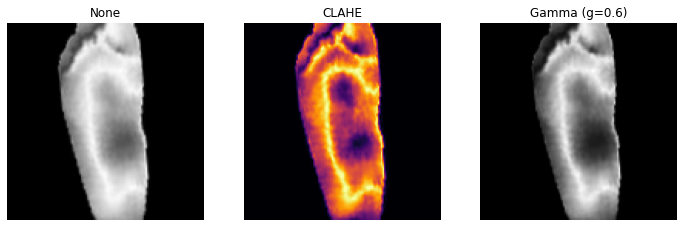

In [58]:

plt.rcParams["figure.figsize"] = (12,6)

traingen = CustomLRDataGen(TrainRight,TrainLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
valgen = CustomLRDataGen(ValRight,ValLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
testgen = CustomLRDataGen(TestRight,TestLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])
itr = traingen.__iter__()
val_itr = valgen.__iter__()
test_itr = testgen.__iter__()
X, y= next(itr)

sample_img = X[0][0]
plt.subplot(1,3,1)
plt.imshow(sample_img, cmap="inferno")
plt.title("None")
plt.axis(False)
plt.subplot(1,3,2)
plt.imshow(adjust_clahe((sample_img)), cmap="inferno")
plt.title("CLAHE")
plt.axis(False)
plt.subplot(1,3,3)
plt.title("Gamma (g=0.6)")
plt.imshow(adjust_gamma((sample_img), gamma=0.5), cmap="inferno")
plt.axis(False)


[0, 0, 1, 0, 0, 1, 1, 0]
[1, 0, 0, 0, 0, 1, 0, 1]


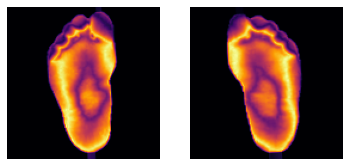

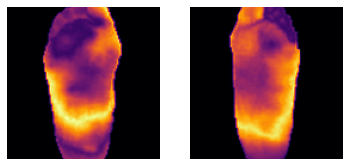

In [59]:
plt.rcParams["figure.figsize"] = (6,6)
# Sanity check to test generator outputs
for i in range(0,2):
  X, y= next(itr)
  print(y)
  plt.figure()
  plt.subplot(1,2,1)
  plt.grid(False)
  plt.axis(False)
  plt.imshow(X[0][0][:,:,0], cmap="inferno")
  plt.subplot(1,2,2)
  plt.grid(False)
  plt.axis(False)
  plt.imshow(X[1][0][:,:,0], cmap="inferno")

###### Install keras-contrib package

In [60]:
!pip install git+https://www.github.com/farizrahman4u/keras-contrib.git
!pip install pydot

  Cloning https://www.github.com/farizrahman4u/keras-contrib.git to /tmp/pip-req-build-5x3wo_k6
  Running command git clone -q https://www.github.com/farizrahman4u/keras-contrib.git /tmp/pip-req-build-5x3wo_k6
  Resolved https://www.github.com/farizrahman4u/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0


In [61]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3), activation=None,
                             padding='same', strides=(1, 1), instance_normalization=False):
    """
    :param strides:
    :param input_layer:
    :param n_filters:
    :param batch_normalization:
    :param kernel:
    :param activation: Keras activation layer to use. (default is 'relu')
    :param padding:
    :return:
    """
    layer = Conv2D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    if batch_normalization:
        layer = BatchNormalization(axis=1)(layer)
    elif instance_normalization:
        try:
            from keras_contrib.layers.normalization import InstanceNormalization
            from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
        except ImportError:
            raise ImportError("Install keras_contrib in order to use instance normalization."
                              "\nTry: pip install git+https://www.github.com/farizrahman4u/keras-contrib.git")
        layer = InstanceNormalization(axis=1)(layer)
    if activation is None:
        return Activation('relu')(layer)
    else:
        return activation()(layer)


#### Attention module

In [62]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
from keras.layers import Input

def attach_attention_module(net, attention_module):
  if attention_module == 'se_block': # SE_block
    net = se_block(net)
  elif attention_module == 'cbam_block': # CBAM_block
    net = cbam_block(net)
  else:
    raise Exception("'{}' is not supported attention module!".format(attention_module))

  return net

def se_block(input_feature, ratio=8):
	"""Contains the implementation of Squeeze-and-Excitation(SE) block.
	As described in https://arxiv.org/abs/1709.01507.
	"""
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	se_feature = GlobalAveragePooling2D()(input_feature)
	se_feature = Reshape((1, 1, channel))(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	se_feature = Dense(channel // ratio,
					   activation='relu',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel//ratio)
	se_feature = Dense(channel,
					   activation='sigmoid',
					   kernel_initializer='he_normal',
					   use_bias=True,
					   bias_initializer='zeros')(se_feature)
	assert se_feature.shape[1:] == (1,1,channel)
	if K.image_data_format() == 'channels_first':
		se_feature = Permute((3, 1, 2))(se_feature)

	se_feature = multiply([input_feature, se_feature])
	return se_feature

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""
	
	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):
	
	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]
	
	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	
	avg_pool = GlobalAveragePooling2D()(input_feature)    
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	
	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	
	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
	
	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7
	
	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature
	
	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)	
	assert cbam_feature.shape[-1] == 1
	
	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)
		
	return multiply([input_feature, cbam_feature])
		

In [17]:
#from load_cifar10 import load_cifar10_data
import keras
def identity_block(input_tensor, kernel_size, filters, stage, block, mask_name):
    """
    The identity_block is the block that has no conv layer at shortcut
    Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch' + mask_name
    bn_name_base = 'bn' + str(stage) + block + '_branch' + mask_name

    x = Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size),
                      padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    #x = merge([x, input_tensor], mode='sum')
    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, mask_name, strides=(2, 2)):
    """
    conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """

    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch' + mask_name
    bn_name_base = 'bn' + str(stage) + block + '_branch' + mask_name

    x = Conv2D(nb_filter1, (1, 1), strides=strides,
                      name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                      name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(nb_filter3, (1, 1), strides=strides,
                             name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    #x = merge([x, shortcut], mode='sum')
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

"""
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""

import tensorflow as tf

# Define ReLU6 activation
relu6 = tf.keras.layers.ReLU(6.)

def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    x = tf.keras.layers.Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    return relu6(x)


def _bottleneck(inputs, filters, kernel, t, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    tchannel = inputs.shape[-1] * t

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = tf.keras.layers.DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = relu6(x)

    x = tf.keras.layers.Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if r:
        x = tf.keras.layers.add([x, inputs])
    return x


def _inverted_residual_block(inputs, filters, kernel, t, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, 1, True)

    return x

def MLP(x,pooling='avg'):
  if pooling == 'avg':
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
  elif pooling == 'max':
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
  # Final Dense Outputting Layer for the outputs
  x = tf.keras.layers.Flatten()(x)
  outputs = tf.keras.layers.Dense(1)(x)
  outputs = tf.keras.layers.Activation("sigmoid", name="final_activation")(outputs)
  return outputs

def MobileNetV2(inputs, k, mask_name, plot_model=False, attention_module="cbam_block"):
    """MobileNetv2
    This function defines a MobileNetv2 architecture.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        plot_model: Boolean, whether to plot model architecture or not
    # Returns
        MobileNetv2 model.
    """
    return_layers = []
    inputs = inputs
    x = _conv_block(inputs, 32, (3, 3), strides=(2, 2))
    y = x
    # attention_module
    if attention_module is not None:
        y = attach_attention_module(x, attention_module)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    
    return_layers.append(x)
    
    x = _inverted_residual_block(x, 16, (3, 3), t=1, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, strides=2, n=2)
    
    return_layers.append(x)

    x = _inverted_residual_block(x, 32, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, strides=2, n=4)
    
    # attention_module
    if attention_module is not None:
        y = attach_attention_module(x, attention_module)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    

    return_layers.append(x)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, strides=1, n=1)
    
    # attention_module
    if attention_module is not None:
        y = attach_attention_module(x, attention_module)
    x = keras.layers.add([x, y])
    x = Activation('relu')(x)
    

    return_layers.append(x)

    # x = _conv_block(x, 1280, (1, 1), strides=(1, 1))
    # x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.Reshape((1, 1, 1280))(x)
    # x = tf.keras.layers.Dropout(0.3, name='Dropout')(x)
    # x = tf.keras.layers.Conv2D(k, (1, 1), padding='same')(x)
    #x = tf.keras.layers.Activation('sigmoid', name=f'final_activation')(x)
    


    
    output = MLP(x)
    return_layers.append(output)
    model = tf.keras.models.Model(inputs, output)
    #model.summary()

    for layer in model.layers:
      layer._name = layer.name + str(f"_{mask_name}")

    

    return model, return_layers

In [18]:
from keras import backend as K

def loss_(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred)

## F1 Score keras  Source: https://datascience.stackexchange.com/a/45166 
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [19]:
def pre_mobilenetv2(inputs,IMG_SHAPE,mask_name):

  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

 
  #x = data_augmentation(inputs)
  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  
  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
  ]
  return_layers = [base_model.get_layer(name).output for name in layer_names]

    

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=return_layers)


  # mobilemodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
  #               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  #               metrics=['accuracy',tf.keras.metrics.AUC()])

  return down_stack, return_layers


#### SiamResnet model

In [63]:
def siam2dresnet_model(input_shape=(128, 128, 3), optimizer=Adam, initial_learning_rate=0.000025, activation_name="sigmoid",plot_model=True, **kwargs):
    inputs_1 = Input(shape=input_shape)
    inputs_2 = Input(shape=input_shape)
    
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


    #input_m_shape = tuple([1] + list(input_shape[1:]))
    #inputs_m1 = Input(input_m_shape)
    #inputs_m2 = Input(input_m_shape)

    downstack1, _ = pre_mobilenetv2(inputs_1, input_shape, mask_name='mask1')
    downstack2, _ = pre_mobilenetv2(inputs_2, input_shape, mask_name='mask2')

    return_layers_1 = downstack1(preprocess_input(inputs_1))
    return_layers_2 = downstack2(preprocess_input(inputs_2))
    
    print(return_layers_1)
    print(return_layers_2)
   
    # _, return_layers_1 = MobileNetV2(inputs_1,1, mask_name='mask1')
    # _, return_layers_2 = MobileNetV2(inputs_2,1, mask_name='mask2')

    sf1_0 = return_layers_1[0] #sf:select feature
    sf2_0 = return_layers_2[0]
    #sf1_0 = BatchNormalization(axis=1)(sf1_0)
    #sf2_0 = BatchNormalization(axis=1)(sf2_0)
    #sf_0 = sf_module(sf1_0, sf2_0, 64)
    #sf_0 = sf_module(sf1_0, sf2_0, 1)
    #sf_0 = Add()([sf1_0, sf2_0]
    sf_0 = Subtract()([sf1_0, sf2_0])
    #sf_0 = concatenate([sf1_0, sf2_0], axis=1)
    sf_0 = create_convolution_block(sf_0, 32)


    #out_sf = Conv3D(1, (36, 36, 36), kernel_initializer=kernel_init(sf1_1))(sf2_1)

    sf1_1 = return_layers_1[1]
    sf2_1 = return_layers_2[1]
    #sf1_1 = InstanceNormalization(axis=1)(sf1_1)
    #sf2_1 = InstanceNormalization(axis=1)(sf2_1)
    #sf_1 = sf_module(sf1_1, sf2_1, 256)
    #sf_1 = sf_module(sf1_1, sf2_1, 1)
    #sf_1 = Add()([sf1_1, sf2_1])
    sf_1 = Subtract()([sf1_1, sf2_1])
    sf_1 = create_convolution_block(sf_1, 32)


    sf1_2 = return_layers_1[2] 
    sf2_2 = return_layers_2[2]
    #sf_2 = sf_module(sf1_2, sf2_2, 3)
    #sf_2 = sf_module(sf1_2, sf2_2, 1)
    sf_2 = Subtract()([sf1_2, sf2_2])
    sf_2 = create_convolution_block(sf_2, 32)

    sf1_3 = return_layers_1[3] 
    sf2_3 = return_layers_2[3]
    #sf_2 = sf_module(sf1_2, sf2_2, 3)
    #sf_2 = sf_module(sf1_2, sf2_2, 1)
    sf_3 = Subtract()([sf1_3, sf2_3])
    sf_3 = create_convolution_block(sf_3, 32)


    # out_pred_mask_1 = return_layers_1[-1]
    # out_pred_mask_2 = return_layers_2[-1]

    sf_0 = GlobalAveragePooling2D()(sf_0)
    sf_1 = GlobalAveragePooling2D()(sf_1)
    sf_2 = GlobalAveragePooling2D()(sf_2)
    sf_3 = GlobalAveragePooling2D()(sf_3)
    

    sf_add = Add()([sf_0, sf_1, sf_2,sf_3])
    #sf_add = concatenate([sf_0, sf_1, sf_2], axis=1)

    #sf_0 = GlobalAveragePooling3D()(sf_0)
    #sf_1 = GlobalAveragePooling3D()(sf_1)



    #sf_0 = Lambda(print_output, arguments={'msg':' sf_0'})(sf_0)
    #sf_1 = Lambda(print_output, arguments={'msg':' sf_1'})(sf_1)

    #sf_0_max = Lambda(print_output_max, arguments={'msg':' sf_0_max'})(sf_0)
    #sf_1_max = Lambda(print_output_max, arguments={'msg':' sf_1_max'})(sf_1)


    #sf_add = concatenate([sf_0, sf_1], axis=1)
    #sf_add = Lambda(print_output, arguments={'msg':' sf_add'})(sf_add)

    #out_m1 = GlobalAveragePooling3D()(out_pred_mask_1)

    #sf_add = GlobalAveragePooling3D()(sf1_1)


    #out_pred_score = Activation(activation_name)(sf_add)

    #for i in range(len(out_pred_score.shape)-1):
    #    out_pred_score = K.squeeze(out_pred_score, axis=-1)

    #out_pred_score = Reshape(target_shape=())(out_pred_score)

    sf_add = Flatten()(sf_add)



    # out_pred_score = Dense(1, activation=activation_name, name='score')(sf_add)
    # out_pred_score = Dense(1, activation=activation_name)(sf_add)

    #sf_add = Dense(10, activation='relu', kernel_initializer='Ones')(sf_add)
    #sf_add = Dense(10, activation='relu')(sf_add)
    #sf_add = Lambda(print_output, arguments={'msg':' sf_add'})(sf_add)

    sf_add = Dropout(0.4)(sf_add)

    #out_pred_score = Dense(1, activation=None, kernel_initializer='Ones')(sf_add)
    #out_pred_score = Dense(1, activation=None, kernel_regularizer=regularizers.l2(0.01))(sf_add)
    out_pred_score = Dense(256, activation=None, kernel_regularizer=regularizers.l2(0.1))(sf_add)
    out_pred_score = Dense(128, activation=None, kernel_regularizer=regularizers.l2(0.4))(out_pred_score)
    out_pred_score = Dense(1)(out_pred_score)
    
    #out_pred_score = Lambda(print_output, arguments={'msg':' output'})(out_pred_score)
    out_pred_score = Activation(activation_name, name='score')(out_pred_score)
    #out_pred_score = Lambda(print_output, arguments={'msg':' output sigmoid'}, name='score')(out_pred_score)


    #tf.print(out_pred_score)
    #print_layer = Lambda((lambda x: tf.Print(x, [x], 'out_pred_score= ')), name='print')(out_pred_score)
    #print_layer = Lambda((lambda x: tf.Print(x, [x], message='out_pred_score= ', first_n=-1, summarize=1024)), name='print')(out_pred_score)


    model = Model(inputs=[inputs_1, inputs_2], outputs=[out_pred_score])

    #parallel_model = multi_gpu_model(model, gpus=2)
    # Learning Rate exponential decay
    # lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    # initial_learning_rate,
    # decay_steps=100000,
    # decay_rate=0.96,
    # staircase=False)

    model.compile(optimizer=Adam(learning_rate=initial_learning_rate), 
                  loss={'score':tf.keras.losses.BinaryCrossentropy(from_logits=False)}, 
                  metrics={'score': ["accuracy",tf.keras.metrics.AUC(),f1_m, tf.keras.metrics.Recall(), specificity]})
    #model.compile(optimizer=optimizer(lr=initial_learning_rate), loss={'score':'binary_crossentropy'}, metrics=['accuracy'])
    if plot_model:
        tf.keras.utils.plot_model(model, to_file=f'{CSV_FILE_PATH}model.png', show_shapes=True)

    #model.metrics_tensors += model.outputs
    return model


In [80]:
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import math 
import datetime

name = "AUG2-mobilenetv2-All-pt"

# learning rate schedule
def step_decay(epoch, initial_lrate, drop, epochs_drop):
    return initial_lrate * math.pow(drop, math.floor((1+epoch)/float(epochs_drop)))

# Callbacks while training
def get_callbacks(model_file, initial_learning_rate=0.005, learning_rate_drop=0.3, learning_rate_epochs=None,
                  learning_rate_patience=50, logging_file=f"{CSV_FILE_PATH}{name}-training.log", verbosity=1,
                  early_stopping_patience=None):
    callbacks = list()
    callbacks.append(ModelCheckpoint(filepath=CSV_FILE_PATH + name +'.{epoch:02d}-{val_accuracy:.2f}.h5',save_best_only=True, mode="max", monitor='val_accuracy',initial_value_threshold=0.80))
    callbacks.append(CSVLogger(logging_file, append=True))
    log_dir = CSV_FILE_PATH + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # callbacks.append(tensorboard_callback)

    # Create a callback that saves the model's weights every 5 epochs
    # cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #   filepath=CHECKPOINT_FILE_PATH+"/atten-cp-{epoch:04d}.ckpt", 
    #   verbose=0, 
    #   save_weights_only=True,
    #   save_freq=10)
    #callbacks.append(cp_callback)

 

    if learning_rate_epochs:
        callbacks.append(LearningRateScheduler(partial(step_decay, initial_lrate=initial_learning_rate, drop=learning_rate_drop, epochs_drop=learning_rate_epochs)))
    else:
        callbacks.append(ReduceLROnPlateau(factor=learning_rate_drop, patience=learning_rate_patience,
                                           verbose=verbosity))
    if early_stopping_patience:
        callbacks.append(EarlyStopping(monitor="val_accuracy", verbose=verbosity, patience=early_stopping_patience, min_delta=0.1))
    return callbacks
  
def train_model(model, model_file, training_generator, validation_generator, steps_per_epoch, validation_steps,
                initial_learning_rate=0.005, learning_rate_drop=0.5, learning_rate_epochs=None, n_epochs=85,
                learning_rate_patience=20, early_stopping_patience=None):
    """
    Train a Keras model.
    :param early_stopping_patience: If set, training will end early if the validation loss does not improve after the
    specified number of epochs.
    :param learning_rate_patience: If learning_rate_epochs is not set, the learning rate will decrease if the validation
    loss does not improve after the specified number of epochs. (default is 20)
    :param model: Keras model that will be trained.
    :param model_file: Where to save the Keras model.
    :param training_generator: Generator that iterates through the training data.
    :param validation_generator: Generator that iterates through the validation data.
    :param steps_per_epoch: Number of batches that the training generator will provide during a given epoch.
    :param validation_steps: Number of batches that the validation generator will provide during a given epoch.
    :param initial_learning_rate: Learning rate at the beginning of training.
    :param learning_rate_drop: How much at which to the learning rate will decay.
    :param learning_rate_epochs: Number of epochs after which the learning rate will drop.
    :param n_epochs: Total number of epochs to train the model.
    :return: 
    """

    history = model.fit_generator(generator=training_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=n_epochs, verbose=1,
                        validation_data=validation_generator,
                        validation_steps=validation_steps,
                        callbacks=get_callbacks(model_file,
                                              initial_learning_rate=initial_learning_rate,
                                              learning_rate_drop=learning_rate_drop,
                                              learning_rate_epochs=learning_rate_epochs,
                                              learning_rate_patience=learning_rate_patience,
                                              early_stopping_patience=early_stopping_patience))
    
    pd.DataFrame(history.history).to_csv(f"{CSV_FILE_PATH}{name}-history.csv")
    return history

In [81]:
traingen = CustomLRDataGen(TrainRight,TrainLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["All"])
valgen = CustomLRDataGen(ValRight,ValLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["All"])
testgen = CustomLRDataGen(TestRight,TestLeft,batch_size=8, image_enhancement=ENHANCEMENT_TYPE["None"])

In [82]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
model = siam2dresnet_model(initial_learning_rate=0.0000025)
#model.load_weights(f"{CSV_FILE_PATH}/model5000.08-1.06.h5")

[<tf.Tensor 'model_15/block_1_expand_relu/Relu6:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'model_15/block_3_expand_relu/Relu6:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'model_15/block_6_expand_relu/Relu6:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'model_15/block_13_expand_relu/Relu6:0' shape=(None, 8, 8, 576) dtype=float32>]
[<tf.Tensor 'model_16/block_1_expand_relu/Relu6:0' shape=(None, 64, 64, 96) dtype=float32>, <tf.Tensor 'model_16/block_3_expand_relu/Relu6:0' shape=(None, 32, 32, 144) dtype=float32>, <tf.Tensor 'model_16/block_6_expand_relu/Relu6:0' shape=(None, 16, 16, 192) dtype=float32>, <tf.Tensor 'model_16/block_13_expand_relu/Relu6:0' shape=(None, 8, 8, 576) dtype=float32>]
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [83]:
history = train_model(model, CSV_FILE_PATH ,training_generator=traingen, validation_generator=valgen,validation_steps=5,n_epochs=60, steps_per_epoch=100)

/tmp/ipykernel_99162/2701025035.py:63: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=training_generator,


Epoch 1/60


In [ ]:
#model.load_weights(f"{CSV_FILE_PATH}/pt-mobilenetv4-att-cbam-4.11-0.88.h5")
# Test set evaluation
print("Evaluate on test data")
results = model.evaluate(testgen)
for idx, (n, l) in enumerate(zip(model.metrics_names, results)):
  print(f"{n} : {l}")
df = pd.DataFrame([results], columns=model.metrics_names).to_csv(f"{CSV_FILE_PATH}{name}-test-history.csv")


Evaluate on test data
loss : 52.205848693847656
accuracy : 0.875
auc_4 : 0.9636363983154297
f1_m : 0.8999999761581421
recall_4 : 1.0
specificity : 0.7299796342849731


In [35]:
preds = model.predict(testgen).ravel()

In [27]:
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc,roc_auc_score

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [42]:
testy = np.array([list(testgen)[i][1] for i in range(0, len(testgen))]).ravel()

In [43]:
threshold = Find_Optimal_Cutoff(testy, preds)
print(threshold)

[0.5561023950576782]


AUC: 0.9454545454545454


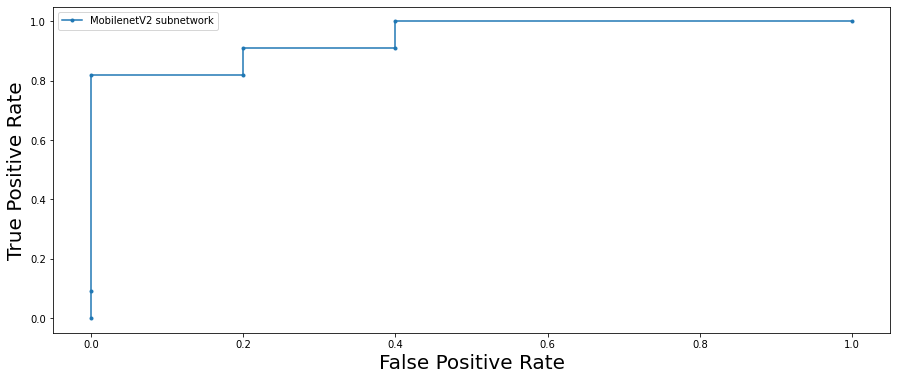

In [46]:
from sklearn.metrics import confusion_matrix

threshPreds = pd.Series(preds).map(lambda x: 1 if x > threshold[0] else 0)

# Print confusion Matrix
confusion_matrix(testy, threshPreds)
font = {'family' : 'normal','size'   : 20}

def plot_roc(preds, testy):

  lr_fpr, lr_tpr, _ = roc_curve(testy, preds)

  # calculate AUC
  auc = roc_auc_score(testy, preds)


  print(f"AUC: {auc}")
  plt.plot(lr_fpr, lr_tpr, marker='.', label=f'MobilenetV2 subnetwork')
  # axis labels
  plt.xlabel('False Positive Rate', **font)
  plt.ylabel('True Positive Rate', **font)
  # show the legend
  plt.legend()
  # show the plot
  plt.show()


plot_roc(preds, testy)

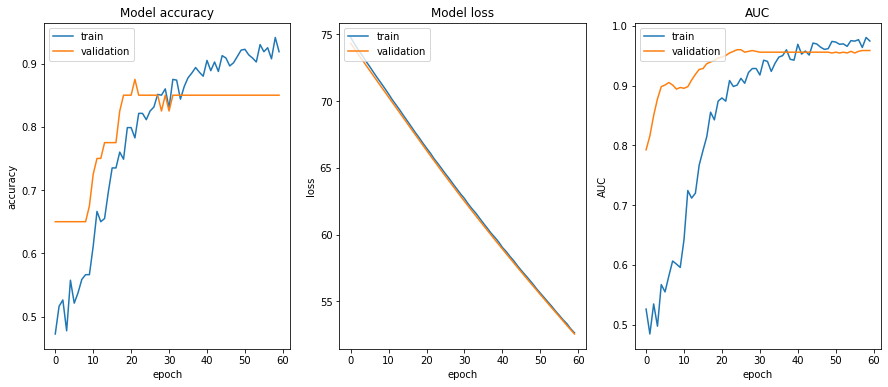

In [45]:
plt.rcParams["figure.figsize"] = (15,6)
# list all data in history
#summarize history for accuracy
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(1,3,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(1,3,3)
# summarize AUC for accuracy
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
def flatten(t):
    out = []
    ll = [item[0] for sublist in t for item in sublist]
    print(ll)
    for idx,v in enumerate(ll):
      if (idx) % 3 == 0:
        out.append(v)
    return out


In [33]:
from sklearn.metrics import roc_curve
y_pred_keras = flatten(model.predict(testgen))
fpr_keras, tpr_keras, thresholds_keras = roc_curve(testgen.labels[:-3], y_pred_keras)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Siamese Resnet (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

/home/saqib/anaconda3/envs/dlenv/lib/python3.10/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


IndexError: invalid index to scalar variable.

In [ ]:
np.save(f'{CSV_FILE_PATH}_5000_siam_res.npy',history.history)

## Grad cam visualization

In [40]:
# import the necessary packages
import cv2
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = [tf.cast(image, tf.float32), tf.cast(image, tf.float32)]
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

    init = tf.compat.v1.global_variables_initializer()
    sess = tf.compat.v1.Session()
    sess.run(init)
      
    cam = cam.eval(session=sess)
    
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    
    heatmap = cv2.resize(cam, (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
    colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

In [41]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf_op_layer_truediv (TensorFlo  [(None, 128, 128, 3  0          ['input_1[0][0]']                
 wOpLayer)                      )]                                                          

In [53]:
tf.config.run_functions_eagerly(True)
#Load model weights
#model.load_weights(f"{CSV_FILE_PATH}model-attention.40-0.85.h5")

gcr = GradCAM(model,0, layerName = "activation_1")
gcl = GradCAM(model,0, layerName = "activation_1")

gc=GradCAM(model,0,layerName="subtract_1")

In [54]:
def generate_maps(times=3):
  plt.rcParams["figure.figsize"] = (4,6)
  itr = traingen.__iter__()
  for i in range(1):
    X, y= next(itr)
    l = np.asarray(X[0][0][:])
    r = np.asarray(X[1][0][:])

    hmr = gcr.compute_heatmap(r[np.newaxis, :])
    hml = gcl.compute_heatmap(l[np.newaxis, :])

    origr = (r).astype(np.uint8)
    origl = (l).astype(np.uint8)

    heatmapr = cv2.resize(hmr, (origr.shape[1], origr.shape[0]))
    heatmapl = cv2.resize(hml, (origl.shape[1], origl.shape[0]))

    (rhm, outputr) = gcr.overlay_heatmap(heatmapr, origr, alpha=0.5)
    (lhm, outputl) = gcr.overlay_heatmap(heatmapl, origl, alpha=0.5)
    plt.figure()
    print(y)
    plt.subplot(1,2,1)
    outputr = np.vstack([origr, outputr,rhm])
    plt.imshow(outputr)
    plt.axis(False)

    plt.subplot(1,2,2)
    outputl = np.vstack([origl, outputl,lhm])
    plt.imshow(outputl)
    plt.axis(False)


[1, 1, 1, 1, 1, 1, 1, 1]


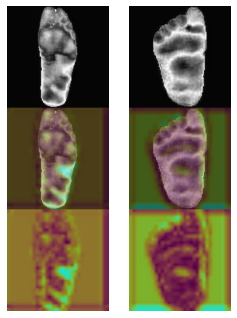

In [55]:
generate_maps()

#### Do not run the below cell. It is for offline data augmentation


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from math import floor

def grayscale_to_rgb(image, channel_axis=-1):
  original = tf.constant(image)
  converted = tf.image.grayscale_to_rgb(original)
  return converted
def augment_images_offline(image_directory_l,image_directory_r, output_dir_l,output_dir_r, prefix):
  datagen = ImageDataGenerator(        
          rotation_range = 5,
          shear_range = 0.1,
          zoom_range = 0.1,
          horizontal_flip = False,
          vertical_flip=False,
          brightness_range = (0.5, 1.0))
  import numpy as np
  import os
  from PIL import Image
  l = image_directory_l
  r = image_directory_r
  dataset_L = []
  dataset_R = []
  l_images = os.listdir(l)
  r_images = os.listdir(r)
  for i, (l_img_n, r_img_n) in enumerate(zip(l_images,r_images)):    
      if (l_img_n.split('.')[1] == 'png' and r_img_n.split(".")[1] == "png"):        
          image_L = io.imread(image_directory_l +"/"+ l_img_n)
          image_R = io.imread(image_directory_r +"/"+ r_img_n)


          image_L = grayscale_to_rgb(np.expand_dims(image_L, axis=2))    
          image_R = grayscale_to_rgb(np.expand_dims(image_R, axis=2))     
          dataset_L.append(np.array(image_L.numpy().squeeze()))
          dataset_R.append(np.array(image_R.numpy().squeeze()))

  x_L = np.array(dataset_L)
  x_R = np.array(dataset_R)
  i = 0
  for batch in datagen.flow(x_L, batch_size=16,
                            shuffle=False,
                            save_to_dir=output_dir_l,
                            save_prefix=prefix,
                            save_format='png', seed=42):    
      i += 1    
      if i > 100:        
          break
  i=0
  for batch in datagen.flow(x_R, batch_size=16,
                            shuffle=False,
                            save_to_dir=output_dir_r,
                            save_prefix=prefix,
                            save_format='png', seed=42):    
      i += 1    
      if i > 100:        
          break

In [ ]:
augment_images_offline(IMG_PATH+"/DM_L/",IMG_PATH+"/DM_R/", IMG_PATH+"/Augmented/DM_L",IMG_PATH+"/Augmented/DM_R", prefix="DM")


In [ ]:
augment_images_offline(IMG_PATH+"/CG_L/",IMG_PATH+"/CG_R/", IMG_PATH+"/Augmented/CG_L",IMG_PATH+"/Augmented/CG_R", prefix="CG")
